## Directional Distance Function Experiments
This notebooks contains experiments in using a directional distance field for visibility in RENI-NeuS

In [ ]:
# set visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [1]:
import os
os.chdir("/workspace/")
import sys
sys.path.append("/workspace/reni_neus")


import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import plotly.graph_objects as go
from torch.utils.data import Dataset

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.cameras.rays import RayBundle
from nerfstudio.utils.colormaps import apply_depth_colormap
from nerfstudio.field_components.encodings import SHEncoding, NeRFEncoding
import tinycudann as tcnn

from reni_neus.reni_neus_model import RENINeuSFactoModelConfig, RENINeuSFactoModel
from reni_neus.utils.utils import get_directions, get_sineweight, look_at_target
from reni_neus.illumination_fields.reni_field import RENIField
from reni_neus.data.reni_neus_datamanager import RENINeuSDataManagerConfig, RENINeuSDataManager
from reni_neus.reni_neus_config import RENINeuS as RENINeuSMethodSpecification, DirectionalDistanceField

def sRGB(imgs):
    # Add batch dimension if necessary
    if imgs.ndim == 3:
        imgs = imgs.unsqueeze(0)
    
    # Calculate the 98th percentile for each image
    q = torch.quantile(imgs.view(imgs.size(0), -1), 0.98, dim=1)
    
    # Normalize images by their 98th percentile
    imgs = imgs / q.view(-1, 1, 1, 1)
    
    # Clamp the pixel values between 0.0 and 1.0
    imgs = torch.clamp(imgs, 0.0, 1.0)
    
    # Convert linear RGB to sRGB using the sRGB conversion formula
    mask = imgs <= 0.0031308
    imgs_sRGB = imgs = torch.where(
        imgs <= 0.0031308,
        12.92 * imgs,
        1.055 * torch.pow(torch.abs(imgs), 1 / 2.4) - 0.055,
    )
    return imgs_sRGB

def rotation_matrix(axis, angle):
    """
    Return 3D rotation matrix for rotating around the given axis by the given angle.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

config = DirectionalDistanceField.config
pipeline_config = config.pipeline

datamanager: VanillaDataManager = pipeline_config.datamanager.setup(
    device=device, test_mode=test_mode, world_size=world_size, local_rank=local_rank, 
)
datamanager.to(device)

model = pipeline_config.model.setup(
    scene_box=datamanager.train_dataset.scene_box,
    num_train_data=len(datamanager.train_dataset),
    metadata=datamanager.train_dataset.metadata,
)
model.to(device)

print('Model loaded')

Variable resolution, using variable_res_collate

Setting up training dataset...

Caching all 160 images.

Output()

Setting up evaluation dataset...

Caching all 5 images.

Output()

Model loaded


mlp($\hat{x}, d$) where $x = \hat{x}r$

$||x|| = ||d|| = 1$

Losses:

1. DDF->SDF Level Set 
2. Ray Hit Probability Supervision -> SDF Accumulation 
3. SDF Expected Termination Supervisioni -> SDF Accumulation
4. Multiview consitancy -> other point on sphere $x_{2}$ looking at same point must have $f_{\text{DDF}} <= 


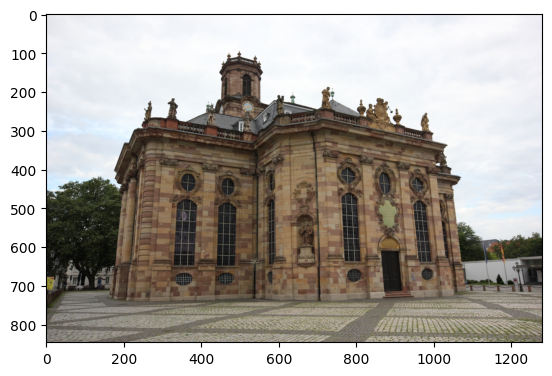

In [2]:
ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(0)
plt.imshow(batch['image'].cpu().numpy())

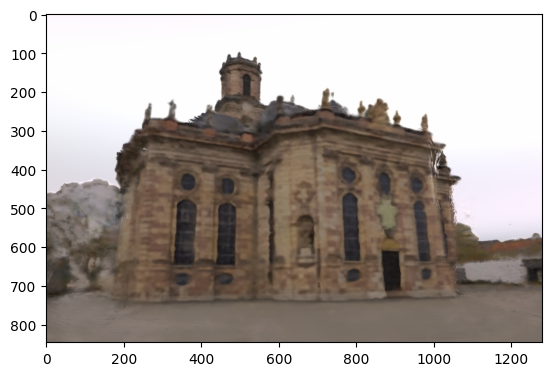

In [5]:
outputs = model.reni_neus.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=True)
plt.imshow(outputs['rgb'].cpu().numpy())

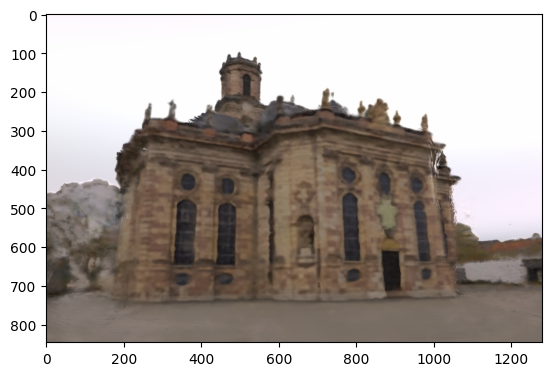

In [7]:
model.reni_neus.field.parameters

<bound method Module.parameters of SDFAlbedoField(
  (spatial_distortion): SceneContraction()
  (embedding_appearance): Embedding(
    (embedding): Embedding(160, 32)
  )
  (encoding): Encoding(n_input_dims=3, n_output_dims=32, seed=1337, dtype=torch.float16, hyperparams={'base_resolution': 16, 'hash': 'CoherentPrime', 'interpolation': 'Smoothstep', 'log2_hashmap_size': 19, 'n_features_per_level': 2, 'n_levels': 16, 'otype': 'Grid', 'per_level_scale': 1.3819128274917603, 'type': 'Hash'})
  (position_encoding): NeRFEncoding()
  (direction_encoding): NeRFEncoding()
  (glin0): Linear(in_features=71, out_features=256, bias=True)
  (glin1): Linear(in_features=256, out_features=256, bias=True)
  (glin2): Linear(in_features=256, out_features=256, bias=True)
  (glin3): Linear(in_features=256, out_features=185, bias=True)
  (glin4): Linear(in_features=256, out_features=256, bias=True)
  (glin5): Linear(in_features=256, out_features=257, bias=True)
  (deviation_network): LearnedVariance()
  (cli

In [16]:
# get the c2w matrix of the camera
idx = 0
old_c2w = datamanager.eval_dataloader.cameras[idx].camera_to_worlds.detach().clone() # [3, 4]
new_pos = old_c2w[:3, 3].detach().clone() # [3]
new_pos = new_pos / torch.norm(new_pos) # on the unit sphere

new_c2w = look_at_target(new_pos.cpu(), torch.tensor([-0.1, 0.5, 0.3]))[:3, :4] # [3, 4] # C2W matrix looking at the center of the scene

datamanager.eval_dataloader.cameras.camera_to_worlds[idx].copy_(new_c2w)

camera_ray_bundle, batch = datamanager.eval_dataloader.get_data_from_image_idx(idx)

model.reni_neus.config.eval_num_rays_per_chunk = 2048

outputs = model.reni_neus.get_outputs_for_camera_ray_bundle(camera_ray_bundle, show_progress=True)

# set the c2w matrix back to the original one
datamanager.eval_dataloader.cameras.camera_to_worlds[idx].copy_(old_c2w)

Output()

tensor([[ 0.9296, -0.1277, -0.3459, -0.6039],
        [-0.3687, -0.3220, -0.8720, -0.7704],
        [ 0.0000,  0.9381, -0.3464, -0.2046]], device='cuda:0')

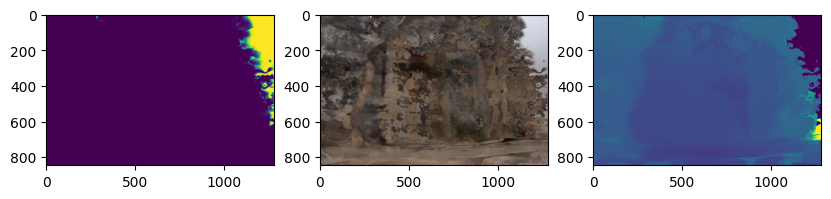

In [4]:
accumulation = outputs['accumulation'].cpu().detach().numpy()
visibiltiy = 1.0 - accumulation
rgb = outputs['rgb'].cpu().detach().numpy()
depth = outputs['p2p_dist'].cpu().detach().numpy()
depth = depth * (outputs['accumulation'] > 0.7).float().cpu().detach().numpy()

# plot both in the same figure
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(visibiltiy)
ax[1].imshow(rgb)
ax[2].imshow(depth, vmin=0, vmax=1.0)

In [18]:
outputs = model.reni_neus.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=True)

Output()

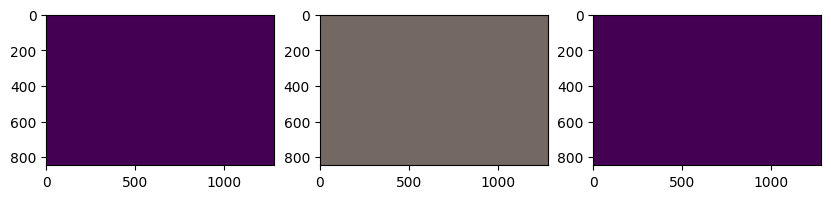

In [19]:
accumulation = outputs['accumulation'].cpu().detach().numpy()
visibiltiy = 1.0 - accumulation
rgb = outputs['rgb'].cpu().detach().numpy()
depth = outputs['p2p_dist'].cpu().detach().numpy()
depth = depth * (outputs['accumulation'] > 0.7).float().cpu().detach().numpy()

# plot both in the same figure
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(visibiltiy)
ax[1].imshow(rgb)
ax[2].imshow(depth, vmin=0, vmax=1.0)

In [6]:
output = model.get_outputs_for_camera_ray_bundle(ray_bundle)

Output()

In [7]:
output['expected_termination_dist'].shape

torch.Size([847, 1280, 1])

In [15]:
plt.imshow(outputs['image'].cpu().numpy())

NameError: name 'outputs' is not defined